In [1]:

import os 
os.chdir(os.path.dirname(os.getcwd()))
print("Current Working Directory " , os.getcwd())


Current Working Directory  /media/david-norato/4fa9159e-57d6-4c0d-badf-c2efbd9cf8e6/david-norato/Documentos/Investigaciones/pycolibri


GPU support:  True
Loading dataset:  cifar10
Files already downloaded and verified
Files already downloaded and verified


/home/david-norato/miniconda3/envs/colibri_hdsp/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


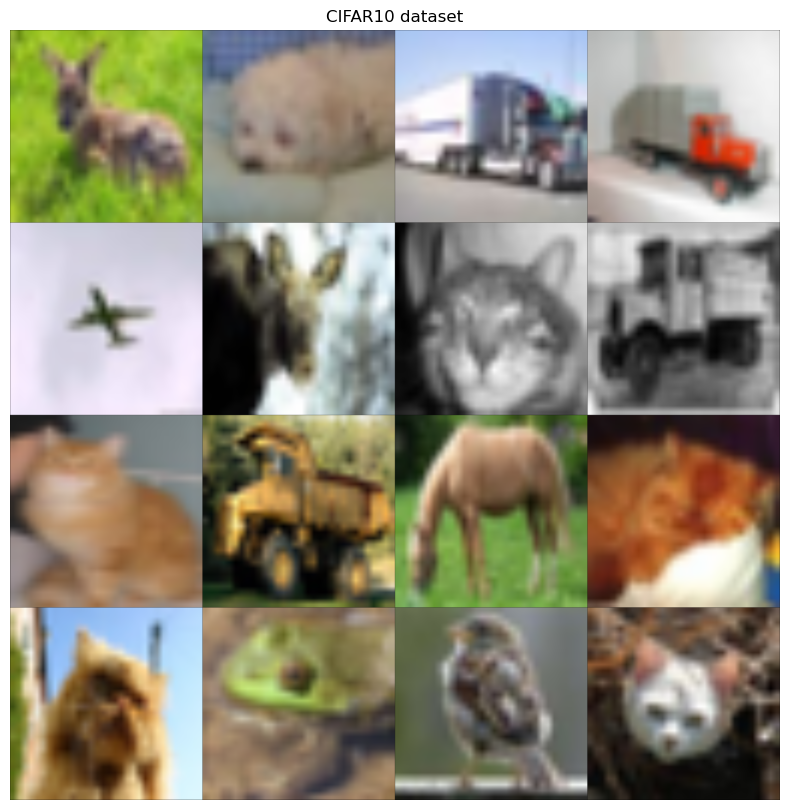

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from colibri.optics.functional import psf_single_doe_spectral, convolutional_sensing, ideal_panchromatic_sensor
from colibri.optics.sota_does import spiral_doe, fresnel_lens, spiral_refractive_index, nbk7_refractive_index
from colibri.optics import SingleDOESpectral




#General imports
import matplotlib.pyplot as plt
import torch
import os

manual_device = "cpu"
wave_resolution=(1000, 1000)
type_doe = "fresnel" # spiral, fresnel_lens
wavelengths=torch.Tensor([450, 550, 650])*1e-9

# Check GPU support
print("GPU support: ", torch.cuda.is_available())

if manual_device:
    device = manual_device
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# %%
# Load dataset
# -----------------------------------------------
from colibri.data.datasets import Dataset

dataset_path = 'cifar10'
keys = ''
batch_size = 16
dataset = Dataset(dataset_path, keys, batch_size)


# %%
# Visualize dataset
# -----------------------------------------------
from torchvision.utils import make_grid
import torchvision

sample = next(iter(dataset.train_dataset))[0]

sample = torchvision.transforms.functional.resize(sample, wave_resolution)
img = make_grid(sample, nrow=4, padding=1, normalize=True, scale_each=False, pad_value=0)

plt.figure(figsize=(10,10))
plt.imshow(img.permute(1, 2, 0))
plt.title('CIFAR10 dataset')
plt.axis('off')
plt.show()



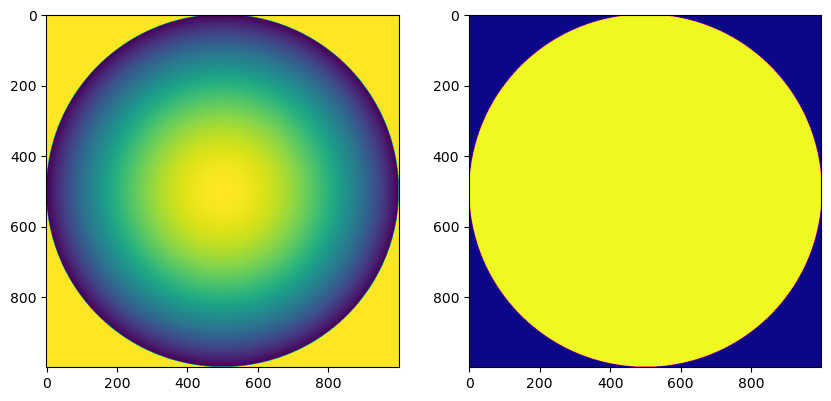

In [3]:


#source_distance = np.inf
source_distance = 150e-3


if type_doe == "spiral":
    radius_doe = 0.5e-3
    sensor_distance=50e-3
    pixel_size = (2*radius_doe)/np.min(wave_resolution)
    height_map, aperture = spiral_doe(ny = wave_resolution[0], nx = wave_resolution[1], 
                    number_spirals = 3, radius = radius_doe, 
                    focal = 50e-3, start_w = 450e-9, end_w = 650e-9)
    refractive_index = spiral_refractive_index

else:
    radius_doe =  2.5e-3
    focal = 50e-3

    if source_distance == np.inf:
        source_distance=focal*0.88
    else:
        sensor_distance= 0.95/(1/(focal) - 1/(source_distance))
    pixel_size = (2*radius_doe)/np.min(wave_resolution)
    height_map, aperture = fresnel_lens(ny = wave_resolution[0], nx = wave_resolution[1], focal= focal, radius=radius_doe)
    refractive_index = nbk7_refractive_index


fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(height_map, cmap="viridis")
ax[1].imshow(aperture, cmap="plasma")

## Functional

(-0.5, 4004.5, 4004.5, -0.5)

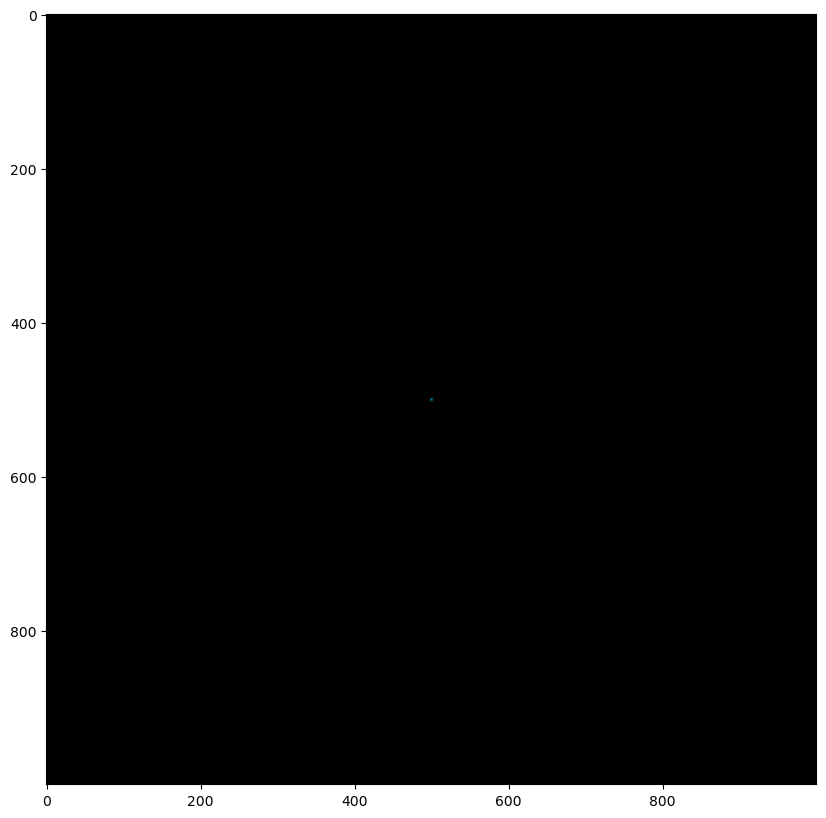

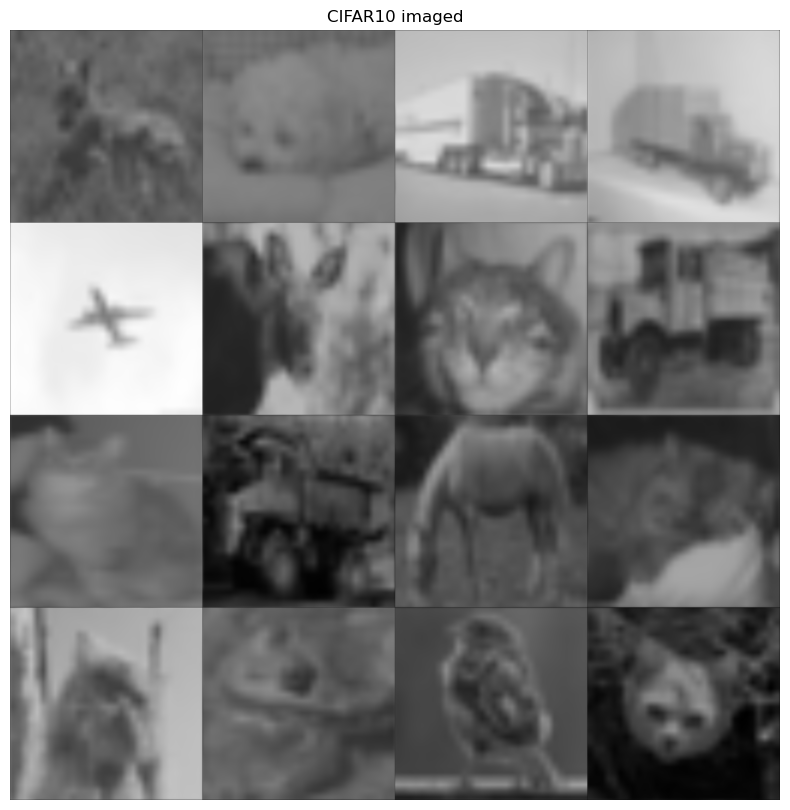

In [4]:



psf = psf_single_doe_spectral(height_map = height_map, aperture=aperture, refractive_index=refractive_index,
                        wavelengths = wavelengths, 
                        source_distance = source_distance, 
                        sensor_distance = sensor_distance, 
                        pixel_size = pixel_size)


psf = (psf - psf.min())/(psf.max()-psf.min())
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(psf.permute(1, 2, 0), cmap="plasma")



field = convolutional_sensing(sample, psf)
image = ideal_panchromatic_sensor(convolutional_sensing(sample, psf))

img = make_grid(image, nrow=4, padding=1, normalize=True, scale_each=False, pad_value=0)

plt.figure(figsize=(10,10))
plt.imshow(img.permute(1, 2, 0))
plt.title('CIFAR10 imaged')
plt.axis('off')



## DOE Class

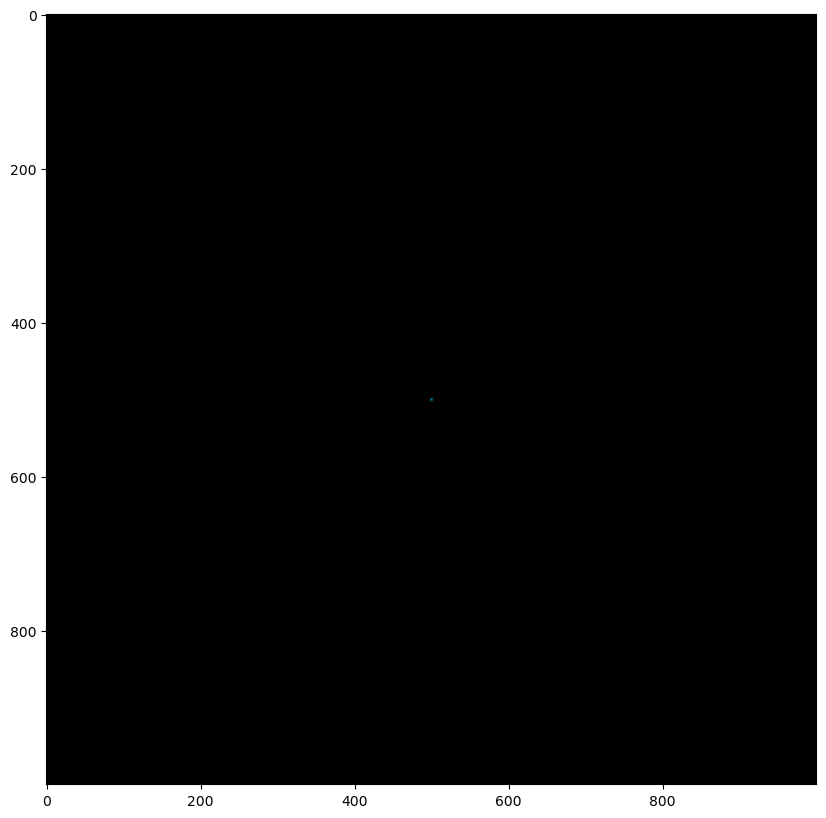

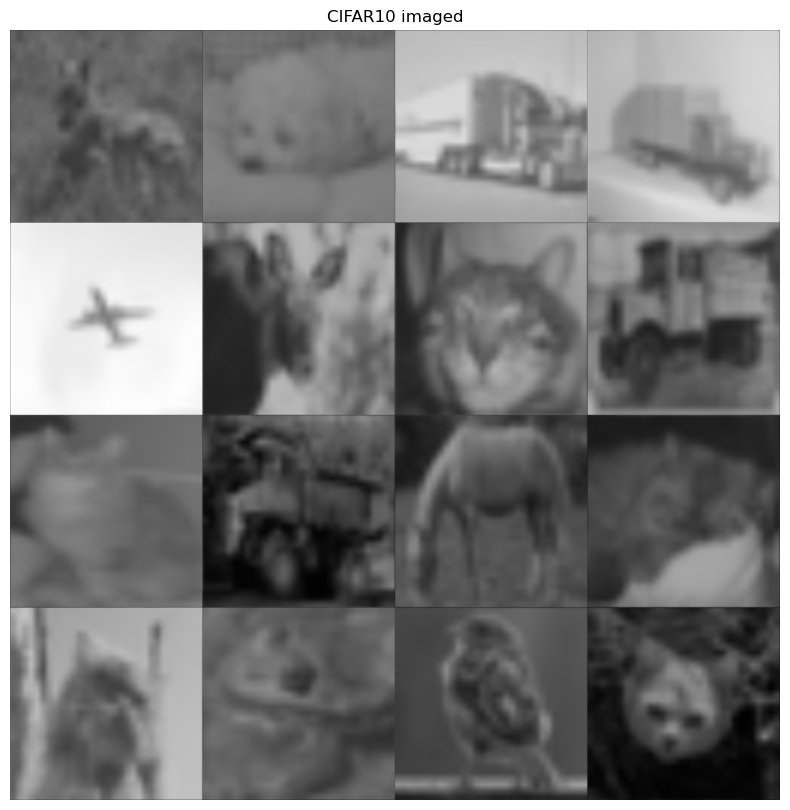

In [5]:
acquisition_model = SingleDOESpectral(input_shape = sample.shape[1:], 
                        height_map = height_map, 
                        aperture = aperture, 
                        wavelengths = wavelengths, 
                        source_distance = source_distance, 
                        sensor_distance = sensor_distance, 
                        pixel_size = pixel_size,
                        trainable = False)

psf = acquisition_model.get_psf()
psf = (psf - psf.min())/(psf.max()-psf.min())
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(psf.permute(1, 2, 0), cmap="plasma")



image = acquisition_model(sample)

img = make_grid(image, nrow=4, padding=1, normalize=True, scale_each=False, pad_value=0)

plt.figure(figsize=(10,10))
plt.imshow(img.permute(1, 2, 0))
plt.title('CIFAR10 imaged')
plt.axis('off')


plt.show()



